# Face Recognition Master

## 引入必要的库

In [10]:
import face_recognition
import pandas as pd
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import seaborn as sns

import pickle
import tqdm
import os
import seaborn
import time

## 初始设置

In [2]:
train_dir = os.listdir('gt_db/')

## 遍历图片数据

In [3]:
def generate_file(train_dir):
    encodings = []
    names = []
    for person in tqdm.tqdm(train_dir):
        if ".DS_Store" not in person: 
            pix = os.listdir('gt_db/' + person)  # 人名类似 s01, s02 etc.

            # 遍历该层级下所有照片
            for person_img in pix:
                if ".DS_Store" not in person_img: 
                    # 获取所有面部编码
                    face = face_recognition.load_image_file('gt_db/' + person + "/" + person_img)
                    face_bounding_boxes = face_recognition.face_locations(face, model="cnn")

                    # 可能会出现无法识别/超过一个人的情况
                    if len(face_bounding_boxes) == 1:
                        face_enc = face_recognition.face_encodings(face)[0]
                        # 加入编码
                        encodings.append(face_enc)
                        names.append(person)
                    else:
                        print('Warning: ' + person + "/" + person_img + " was skipped and can't be used for training")
    data_file = open('data_list.p', 'wb')
    pickle.dump([encodings, names], data_file)
    data_file.close()
    print('data_list.p has been generated in the root')

In [4]:
def get_lib(lib_path, suffix='jpg'):
    ret = []
    for root, dirs, files in os.walk(lib_path):
        for file in files:
            # 获取文件名, 文件路径
            suf = file.split('.')[-1]
            if suf == suffix:
                if suffix == 'jpg':
                    ret.append([str(os.path.join(root, file)).split('/')[1], os.path.join(root, file)])
                else:
                    ret.append(os.path.join(root, file))
    return ret

# get_lib('gt_db/')

In [5]:
re_generate = False

if not re_generate:
    data_file = open('data_list.p', 'rb') 
    lists = pickle.load(data_file)
    encodings = lists[0]
    names = lists[1]
    data_file.close()
else:
    generate_file(train_dir)
    


### SVC Classifier

In [12]:
# 使用SVC分类器
X_train, X_test, y_train, y_test = train_test_split(encodings, names, test_size=0.2, random_state=42)

clf = svm.SVC(gamma='scale')
clf.fit(X_train, y_train)

SVC()

## 验证

In [13]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
#定义和绘制混淆矩阵
def get_confusion_matrix(trues, preds):
  conf_matrix = confusion_matrix(trues, preds, sample_weight=None)
  return conf_matrix

def plot_confusion_matrix(conf_matrix):
  plt.imshow(conf_matrix, cmap=plt.cm.Blues)#可以改变颜色
  indices = range(conf_matrix.shape[0])
  plt.colorbar()
  plt.xlabel('prediction')
  plt.ylabel('true value')
  # 显示数据
  for first_index in range(conf_matrix.shape[0]):#trues
    for second_index in range(conf_matrix.shape[1]):#preds
      plt.text(first_index, second_index, conf_matrix[first_index, second_index])
#   plt.savefig('heatmap_confusion_matrix.jpg')
  plt.show()

Test score: 0.9533333333333334
Cross validation scores: [1. 1. 1. 1. 1.]
准确率为： 0.9533333333333334


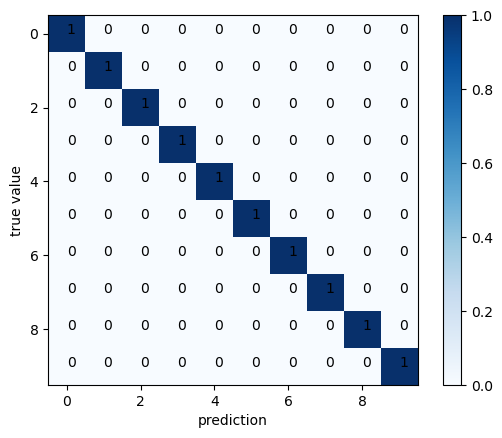

In [14]:
scores_test = clf.score(X_test, y_test)
print("Test score: {}".format(scores_test))

scores_cv = cross_val_score(clf, encodings, names, cv=5)
print("Cross validation scores: {}".format(scores_cv))

prediction = clf.predict(X_test)
print('准确率为：',metrics.accuracy_score(prediction, y_test))


y_test_predict = clf.predict(X_test)
plot_confusion_matrix(metrics.confusion_matrix(y_test[:10], y_test_predict[:10], labels=None, sample_weight=None))

## 实例

In [18]:

# 载入数据
test_image = face_recognition.load_image_file('test.jpg')

# Find all the faces in the test image using the default HOG-based model
face_locations = face_recognition.face_locations(test_image)
no = len(face_locations)
print("Number of faces detected: ", no)

# Predict all the faces in the test image using the trained classifier
print("Found:")
for i in range(no):
    start = time.time()
    test_image_enc = face_recognition.face_encodings(test_image, model="cnn")[i]
    end = time.time()
    name = clf.predict([test_image_enc])
    print(*name)
    print(end - start)

Number of faces detected:  1
Found:
s21
0.1194307804107666


In [2]:
clf = svm.SVC()

In [3]:
type(clf)

sklearn.svm._classes.SVC

In [ ]:
prediction=svm_model.predict(x_test.astype("int"))
print('准确率为：',metrics.accuracy_score(prediction, y_test.astype("int")))

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
import time


clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = svm.SVC(kernel='linear')
clf4 = MLPClassifier(hidden_layer_sizes=(64),max_iter=10000)

X_train, X_test, y_train, y_test = train_test_split(encodings, names, test_size=0.2, random_state=42)

run_times = []
scores_mean = []
score_std = []

for clf, label in zip([clf1, clf2, clf3, clf4], [
        'Logistic Regression', 'Random Forest', 'SVM', 'MLP'
]):
    start = time.time()
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    end = time.time()
    running_time = end - start
    print("Accuracy: %0.8f (+/- %0.2f),耗时%0.2f秒。模型名称[%s]" %
          (scores.mean(), scores.std(), running_time, label))
    run_times.append(running_time)
    scores_mean.append(round(scores.mean(), 4))
    score_std.append(round(scores.std(), 4))


Accuracy: 0.98663866 (+/- 0.00),耗时0.47秒。模型名称[Logistic Regression]
Accuracy: 0.99833333 (+/- 0.00),耗时3.04秒。模型名称[Random Forest]
Accuracy: 0.98663866 (+/- 0.00),耗时0.11秒。模型名称[SVM]
Accuracy: 1.00000000 (+/- 0.00),耗时17.40秒。模型名称[MLP]


In [19]:
name = ['Logistic Regression', 'Random Forest', 'SVM', 'MLP']

time_dict = dict(zip(name, run_times))


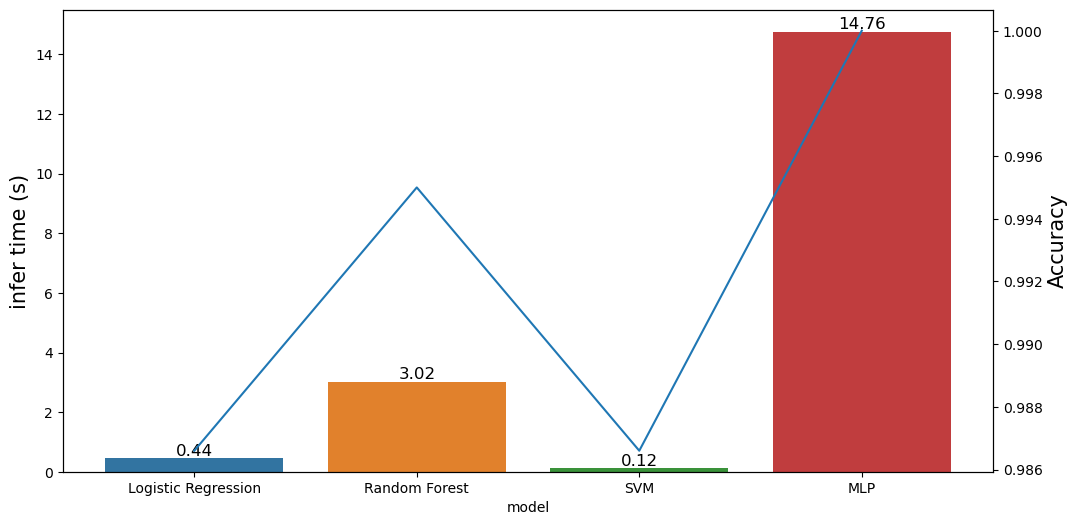

In [27]:
df = pd.DataFrame()
df['time'] = run_times
df['model'] = name
df['performance'] = scores_mean
# p1=sns.barplot(data=df, x='model', y='time')
# plt.show()

plt.rcParams['figure.figsize'] = (12.0,6.0)
fig = plt.figure()
#画柱形图
ax1 = fig.add_subplot(111)
p1=sns.barplot(data=df, x='model', y='time' )
ax1.set_ylabel('infer time (s)',fontsize='15')

#画折线图 
ax2 = ax1.twinx()   #组合图必须加这个
ax2.plot(df['model'], df['performance'], ms=10)
ax2.set_ylabel('Accuracy',fontsize='15')

for bars in ax1.containers:
     ax1.bar_label(bars, fontsize=12, fmt='%.2f')
        

plt.show()

0    0.587622
1    1.984591
2    1.606846
3    0.105881
dtype: float64